In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

In [8]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [9]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_brooklyn"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067136 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067205 > 1.066667). Truncating to maximum value.


10


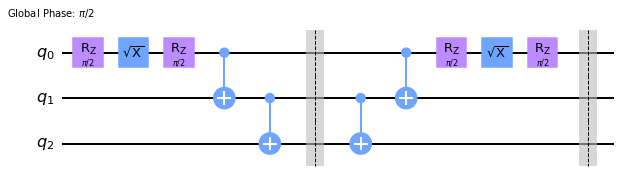

In [10]:
n_qubits = 3
reps = 8
max_num_itrs = 10

temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [15]:
temp_circ2 = iterative_circ(1, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 11
T1: 9.10071570597888e-05 sec
T2: 0.00011441419132906677 sec
Circuit Operation Time: 5.720888888888888e-06 sec


In [13]:
temp_sch.stop_time

99472

In [14]:
temp_sch.start_time

0